<a href="https://colab.research.google.com/github/C00ldudeNoonan/Japan-in-the-Pacific/blob/main/WW2InthePacificFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.1 MB/s 
     |████████████████████████████████| 6.3 MB 42.3 MB/s 
     |████████████████████████████████| 16.7 MB 387 kB/s 


In [2]:
%%time

from shapely import geometry
from shapely.geometry import Point, Polygon
import pandas as pd
from datetime import datetime
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from geopandas import GeoDataFrame
import imageio
import os
import matplotlib.font_manager
import re
import requests
from bs4 import BeautifulSoup


# conquered territory geodataframe

# URL on the Github where the csv files are stored
github_url = 'https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/tree/main/Territory_shapes' 
result = requests.get(github_url)

html = result.text
soup = BeautifulSoup(html)

csvfiles = soup.find_all(title=re.compile("\.shp$"))

filename = [ ]#
for i in csvfiles:
        filename.append(i.extract().get_text())


conquered_territory_shapes = gpd.GeoDataFrame()
base_url = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Territory_shapes/'
for file in filename:
  shape_file = base_url + file
  temp_df = gpd.read_file(shape_file)
  temp_df.crs = "EPSG:4326"
  conquered_territory_shapes = pd.concat([conquered_territory_shapes, temp_df])

conquered_territory_shapes.reset_index(inplace=True, drop=True)



conquered_territory_shapes = conquered_territory_shapes.to_crs("EPSG:3111")

ship_losses = pd.read_csv("https://raw.githubusercontent.com/C00ldudeNoonan/Japan-in-the-Pacific/main/shipdata.csv")


ship_losses['Tonnage'] = ship_losses['Tonnage'].astype(int)
# 3 convert lat and long into float 

ship_losses['Latitiude'] = ship_losses['Latitiude'].astype(float)
ship_losses['Longitude'] = ship_losses['Longitude'].astype(float)
# 4 create geomtery for lat/long

pointgeometry = [Point(xy) for xy in zip(ship_losses['Longitude'],ship_losses['Latitiude'])]
gdf = GeoDataFrame(ship_losses, crs ="EPSG:4326", geometry=pointgeometry)


# index iteratorQ
gdf['Month Index'] = gdf['Month Index'].astype(int)

months = list(gdf['Month Index'].unique())
months.sort()


gdf = gdf.to_crs("EPSG:3111")


gdf['Month_Name'] = gdf['Year'].astype(str) + "-" + gdf['Month'].astype(str)

conquered_territory_shapes = conquered_territory_shapes.merge(gdf, left_on='Name', right_on='Month_Name' )

conquered_territory_shapes = conquered_territory_shapes.drop(columns=['descriptio', 'timestamp', 'begin', 'end', 'altitudeMo', 'tessellate', 'extrude', 
                                                                      'visibility', 'drawOrder', 'icon', 'geometry_y', 'Month_Name',  'index', 'Month',
                                                                      'Day', 'Year', 'Ship Name', 'Ship Type', 'Tonnage', 'Latitiude', 'Longitude', 
                                                                      'Assessment', 'Original Location', 'geometry_y', 'Month_Name'] ) 


shiplosses_url = 'https://raw.githubusercontent.com/C00ldudeNoonan/Japan-in-the-Pacific/main/Total_Ship_Losses.csv'
total_shiplosses = pd.read_csv(shiplosses_url)

production_url = 'https://raw.githubusercontent.com/C00ldudeNoonan/Japan-in-the-Pacific/main/Production.csv'

production = pd.read_csv(production_url)
oil_stocks = production[production['Type']=='Oil Stocks']


oil_consumption = production[production['Type']=='Oil Consumption']
oil_production = production[production['Type']=='Crude Oil Production']
oil_imports = production[production['Type']=='Oil Imports']
totals = production[production['Type'].isin(['Oil Consumption','Crude Oil Production', 'Oil Imports']) ].groupby('Date').sum()
totals_offset = production[production['Type'].isin(['Crude Oil Production', 'Oil Imports']) ].groupby('Date').sum()

totals = totals.merge(totals_offset, left_on='Date', right_on='Date')


conquered_territory_shapes.drop_duplicates(inplace=True)
#conquered_territory_shapes.rename({'geometry_x': 'geometry'}, inplace=True)
#print(conquered_territory_shapes.columns)
conquered_territory_shapes = gpd.GeoDataFrame(conquered_territory_shapes, geometry='geometry_x')

# Intiail country border shapefile
Canvas = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/cntry1938.shp'
Canvas = gpd.read_file(Canvas)
Canvas.crs = "EPSG:4326"

# Ocean Shapefiles

SouthChinaSea = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/SouthChinaSea.shp' 
SouthChinaSea = gpd.read_file(SouthChinaSea)
SouthChinaSea.crs = "EPSG:4326"
SouthChinaSea = SouthChinaSea.to_crs("EPSG:3111") 

SouthPacific = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/SouthEastPacific.shp' 
SouthPacific = gpd.read_file(SouthPacific)
SouthPacific.crs = "EPSG:4326"
SouthPacific = SouthPacific.to_crs("EPSG:3111") 

IndianOcean = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/IndianOcean.shp' 
IndianOcean = gpd.read_file(IndianOcean)
IndianOcean.crs = "EPSG:4326"
IndianOcean = IndianOcean.to_crs("EPSG:3111") 

NorthPacific = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/NorthPacific.shp' 
NorthPacific = gpd.read_file(NorthPacific)
NorthPacific.crs = "EPSG:4326"
NorthPacific = NorthPacific.to_crs("EPSG:3111") 

# Minor Geographic features
RiversAndLakes = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/RiversAndLakes.shp' 
RiversAndLakes = gpd.read_file(RiversAndLakes)
RiversAndLakes.crs = "EPSG:4326"
RiversAndLakes = RiversAndLakes.to_crs("EPSG:3111")

Reefs = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/Reefs.shp' 
Reefs = gpd.read_file(Reefs)
Reefs.crs = "EPSG:4326"
Reefs = Reefs.to_crs("EPSG:3111")

MinorIslands = '/vsicurl/https://github.com/C00ldudeNoonan/Japan-in-the-Pacific/raw/main/Geographic_shapes/MinorIslands.shp' 
MinorIslands = gpd.read_file(MinorIslands)
MinorIslands.crs = "EPSG:4326"
MinorIslands = MinorIslands.to_crs("EPSG:3111")


Canvas = Canvas[~Canvas['NAME'].isin(['Antarctica', 'Greenland'])]
Canvas = Canvas.to_crs("EPSG:3111") 

# countries
Japan = Canvas[Canvas['NAME'].isin(['Japan', 'Taiwan'])]
UnitedStates = Canvas[Canvas['NAME']=='United States']
Mexico = Canvas[Canvas['NAME']=='Mexico']
China = Canvas[Canvas['NAME']=='China']
DutchEastIndies = Canvas[Canvas['NAME']=='Dutch East Indies']
Britain = Canvas[Canvas['NAME'].isin(['Ceylon', 'Malaysia','Burma', 'Brunei'])]
NewZealand = Canvas[Canvas['NAME']=='New Zealand']
Australia = Canvas[Canvas['NAME'].isin(['Australia', 'Papua New Guinea'])]
USSR = Canvas[Canvas['NAME'].isin(['USSR', 'Mongolia'])]
India = Canvas[Canvas['NAME']=='India']
FrenchIndoChina = Canvas[Canvas['NAME'].isin(['French Indo-China', 'Cochin China'])]
Manchuria = Canvas[Canvas['NAME']=='Manchuria']
Laos = Canvas[Canvas['NAME']=='Laos']
Philippines = Canvas[Canvas['NAME']=='Philippines']
Thailand = Canvas[Canvas['NAME']=='Thailand']
Tibet = Canvas[Canvas['NAME']=='Tibet']
Cambodia = Canvas[Canvas['NAME']=='Cambodia']
Bhutan = Canvas[Canvas['NAME']=='Bhutan']
Nepal = Canvas[Canvas['NAME']=='Nepal']



aoi_bounds = Canvas[Canvas['NAME']=='Japan'].geometry.total_bounds
plot_bounds = [aoi_bounds[0]+100000, aoi_bounds[1]+100000, aoi_bounds[2]+100000, aoi_bounds[3]+100000 ]
plot_bounds = [aoi_bounds[0]-6000000, aoi_bounds[1]+9000000, aoi_bounds[2]-1800000, aoi_bounds[3]+2660000 ]


def month_name(month_int):
  if month_int ==1:
    return "Jan"
  elif month_int == 2:
    return "Feb"
  elif month_int == 3:
    return "Mar"
  elif month_int == 4:
    return "Apr"
  elif month_int == 5:
    return "May"
  elif month_int == 6:
    return "Jun"
  elif month_int == 7:
    return "Jul"
  elif month_int == 8:
    return "Aug"
  elif month_int == 9:
    return "Sep"
  elif month_int == 10:
    return "Oct"
  elif month_int == 11:
    return "Nov"
  else:
    return "Dec"   




Index(['Name', 'geometry_x', 'Month Index'], dtype='object')
CPU times: user 45.2 s, sys: 2.59 s, total: 47.8 s
Wall time: 4min 42s


'Aug-1945.png'

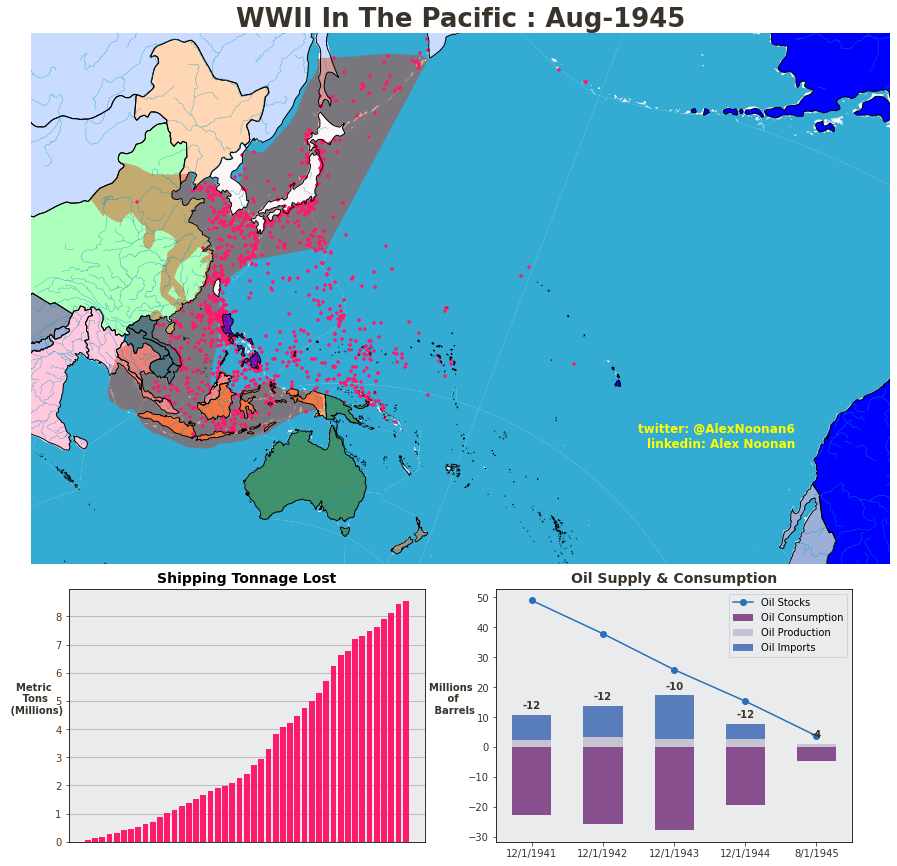

In [8]:
def map_plot_cool_tones(month_index):
  
  fig  = plt.figure(constrained_layout=False, figsize=(60, 20))
  gs1 = fig.add_gridspec(nrows=4, ncols=8, hspace=0.1)
  fig_ax1 = fig.add_subplot(gs1[0:2,:])
  fig_ax2 = fig.add_subplot(gs1[2,3:4])
  fig_ax3 = fig.add_subplot(gs1[2,4:5])
  # Limits
  fig_ax1.set_xlim([plot_bounds[0], plot_bounds[1]])
  fig_ax1.set_ylim([plot_bounds[2], plot_bounds[3]])

  

  Canvas.boundary.plot(ax = fig_ax1, color='black', linewidth=1 )

  # Oceans
  SouthChinaSea.plot(ax=fig_ax1, facecolor='#72ddf7', alpha=1)
  SouthPacific.plot(ax=fig_ax1, facecolor='#72ddf7', alpha=1)
  IndianOcean.plot(ax=fig_ax1, facecolor='#72ddf7', alpha=1) 
  NorthPacific.plot(ax=fig_ax1, facecolor='#72ddf7', alpha=1) 

  # Minor Geographic features
  MinorIslands.plot(ax = fig_ax1, color='black', linewidth=1)
  Reefs.plot(ax = fig_ax1, color="black", linewidth=1)
  RiversAndLakes.plot(ax = fig_ax1, color='#72ddf7', linewidth=0.3)

  # Countries

  UnitedStates.plot(ax = fig_ax1, color='#0000ff', alpha=1) 
  Mexico.plot(ax = fig_ax1, color='#9bafd9', alpha=1) 
  China.plot(ax = fig_ax1, color='#adffbc', alpha=1) 
  DutchEastIndies.plot(ax = fig_ax1, color='#ffa86b', alpha=1) 
  Britain.plot(ax = fig_ax1, color='#ffc8dd', alpha=1) 
  NewZealand.plot(ax = fig_ax1, color='#d264b6', alpha=1)
  Australia.plot(ax = fig_ax1, color='#40916c', alpha=1)
  USSR.plot(ax = fig_ax1, color='#c9dcff', alpha=1)
  India.plot(ax = fig_ax1, color='#ffc8dd', alpha=1) 
  FrenchIndoChina.plot(ax = fig_ax1, color='#00a5cf', alpha=1) 

  Laos.plot(ax = fig_ax1, color='#00a5cf', alpha=1)
  Philippines.plot(ax = fig_ax1, color='#7209b7', alpha=1)
  Thailand.plot(ax = fig_ax1, color='#f2bac9', alpha=1)
  Tibet.plot(ax = fig_ax1, color='#8d99ae', alpha=1)
  Cambodia.plot(ax = fig_ax1, color='#00a5cf', alpha=1)
  Bhutan.plot(ax = fig_ax1, color='#9bafd9', alpha=1)
  Nepal.plot(ax = fig_ax1, color='#9bafd9', alpha=1)
  Manchuria.plot(ax = fig_ax1, color='#ffd7b5', alpha=1)

  # conquered Territories
  conquered_territory_sub = conquered_territory_shapes[conquered_territory_shapes['Month Index']==month_index]
  conquered_territory_sub.plot(ax = fig_ax1, color='#e52c00', alpha= 0.40)
  Japan.plot(ax = fig_ax1, color='#fcf7f6', alpha=1) 
  gdf['MonthName_Letter'] = gdf['Month'].apply(month_name)

  month_label = gdf.loc[gdf['Month Index']==month_index, ['MonthName_Letter','Year']].drop_duplicates()
  month_label.reset_index(drop=True)

  # need sunk ships locations
  # ship plot
  subsetdf = gdf[gdf['Month Index']<=month_index]
  subsetdf.plot(ax = fig_ax1, color='#ff1b6b', markersize=14, marker='+')


  # fix title
  fig_ax1.set_title('WWII In The Pacific : ' + str(month_label.iat[0,0]) + "-" + str(month_label.iat[0,1]), fontsize=26, weight='bold', color="#0e0e52")

  # Shipping plot

  shipping_tonnage_lost = production[production['Type']=='Shipping Tonnage Lost']

  shipping_tonnage_lost.reset_index(drop=True, inplace=True)
  shipping_tonnage_lost.reset_index(drop=False, inplace=True)
  shipping_tonnage_lost_subset = shipping_tonnage_lost[shipping_tonnage_lost['index']<=month_index]



  labels = list(shipping_tonnage_lost_subset['Date'])
  fig_ax2.xaxis.grid()
  fig_ax2.grid(True)
  fig_ax2.bar(labels, shipping_tonnage_lost_subset['Amount'].cumsum()*-1/1000000, color='#ff1b6b', label='Tonnage Lost')
  fig_ax2.get_xaxis().set_visible(False)
  fig_ax2.set_ylabel('Metric \n Tons \n (Millions)', rotation=0, labelpad=20, weight='bold', color="#0e0e52")
  fig_ax2.set_title('Shipping Tonnage Lost' , fontsize=14, weight='bold')
  fig_ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
  fig_ax2.tick_params(axis="y", colors="#0e0e52")
  fig_ax2.set_axisbelow(True)

  ## Oil Plot

  plot_year = datetime.strptime(labels[-1], "%m/%d/%Y").year
  if plot_year==1941:
    ind = 1
  elif plot_year==1942:
    ind = 2
  elif plot_year==1943:
    ind = 3
  elif plot_year==1944:
    ind = 4
  else:
    ind = 5
  labels = list(oil_consumption['Date'][:ind])

  width = 0.55 

  fig_ax3.plot(labels, oil_stocks['Amount'][:ind], color='#2671b8',marker='o', label='Oil Stocks')
  fig_ax3.bar(labels, oil_consumption['Amount'][:ind], width, color='#874f8d', label='Oil Consumption')
  fig_ax3.bar(labels, oil_production['Amount'][:ind], width,color='#c7c3d2', label='Oil Production')
  fig_ax3.bar(labels, oil_imports['Amount'][:ind], width,color='#597dba', label='Oil Imports', bottom=oil_production['Amount'][:ind])
  fig_ax3.set_ylabel('Millions \n of \n Barrels', rotation=0, labelpad=15, weight='bold', color="#0e0e52")
  fig_ax3.set_title('Oil Supply & Consumption', fontsize=14, weight='bold', color="#0e0e52")
  fig_ax3.tick_params(axis="x", colors="#0e0e52")
  fig_ax3.tick_params(axis="y", colors="#0e0e52")
  fig_ax3.legend(loc=1)
  # total data labels

  y_offset = 2
  for index, row in totals[:ind].iterrows():
    fig_ax3.text(index, row['Amount_y'] + y_offset, round(row['Amount_x']), ha='center',
            weight='bold', color='#0e0e52')

  fig.text(0.59, 0.59, 'twitter: @AlexNoonan6\nlinkedin: Alex Noonan', fontsize = 12,
      color ='#ffff01', ha ='right', va ='bottom', weight='bold')
# saving file
  filename = str(month_label.iat[0,0]) + "-" + str(month_label.iat[0,1]) + ".png"
  fig_ax1.axis('off')
  #plt.show()
  plt.savefig(filename, bbox_inches='tight', facecolor='#eaebed')
  plt.close()
  return filename
plt.rcParams['axes.facecolor'] = '#eaebed'

map_plot_cool(45)

In [ ]:
%%time
filenames = []

# loop through and saving gifs for each month; excluding if empty
for month in months:
    if len(gdf[gdf['Month Index']==month]) == 0:
      pass
    else:
      filenames.append(map_plot_cool(month_index=month))

# build gif
with imageio.get_writer('Japan_Timelapse.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        imageframe2 = image
        # imageframe3 = image
        writer.append_data(image)
        writer.append_data(imageframe2)
        # writer.append_data(imageframe3)
# Remove files
for filename in set(filenames):
    os.remove(filename)